<a href="https://colab.research.google.com/github/rbdus0715/Machine-Learning/blob/main/competitions/Spaceship-Titanic/modeling_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[notebook](https://www.kaggle.com/code/viktortaran/space-titanic)

In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.0 MB/s eta 0:00:00


In [2]:
from sklearn.impute import SimpleImputer # null 값 대체하기
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

import optuna # 하이퍼 파라미터 최적화
import xgboost as xgb


import pandas as pd
import numpy as np
import base64 # 인코딩/디코딩

import seaborn as sns
import matplotlib.pyplot as plt

import os
import random
import gc # python 메모리 관리
# python에서 메모리 관리를 위한 글 : (https://medium.com/dmsfordsm/garbage-collection-in-python-777916fd3189)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float6

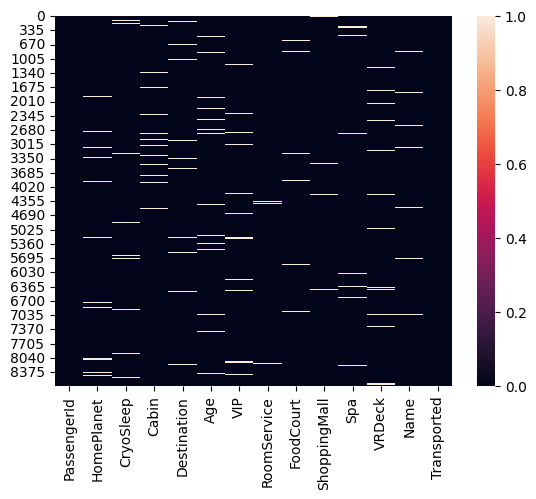

In [5]:
print(train.isnull().sum())
sns.heatmap(train.isnull())
print(train.info())

### train 데이터와 test 데이터를 한 번에 전처리 하기 위해서 두 데이터를 합한다.

<ipython-input-6-7cd916b8a1e7>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test = train.append(test)


<Axes: >

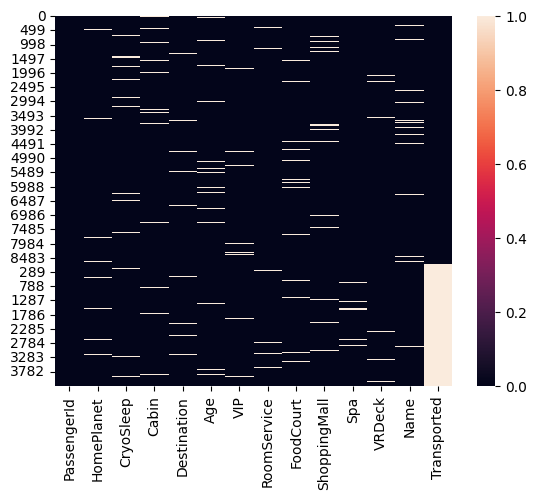

In [6]:
train_test = train.append(test)
sns.heatmap(train_test.isnull())

### **피처 엔지니어링 - 널값 제거**

In [7]:
Expenses_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

수면을 취하고 있는 승객은 지불 비용이 0일 것이다

In [8]:
train_test.loc[:, Expenses_columns] = train_test.apply(lambda x: 0 if x.CryoSleep==True else x, axis=1)

지불 비용이 0인 승객은 수면을 취하고 있을 것이다

In [9]:
train_test['Expenses'] = train_test.loc[:, Expenses_columns].sum(axis=1)
train_test.loc[:, ['CryoSleep']] = train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x, axis=1)

이름 널값도 'unknown'으로 채워놓기

In [10]:
train_test.Name = train_test.Name.fillna('Unknown Unknown')

passengerId를 주의깊게 살펴보면 room 번호를 포함한 것을 알 수 있다.
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

In [11]:
train_test.loc[:,['Room']] = train_test.PassengerId.apply(lambda x: x[0:4])

In [12]:
train_test.loc[:, ['Room', 'VIP']].shape

(12970, 2)

In [13]:
guide_VIP = train_test.loc[:, ['Room', 'VIP']].dropna().drop_duplicates('Room')
guide_Cabin = train_test.loc[:, ['Room', 'Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet = train_test.loc[:, ['Room', 'HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination = train_test.loc[:, ['Room', 'Destination']].dropna().drop_duplicates('Room')

In [14]:
train_test = pd.merge(train_test, guide_Cabin, how='left', on='Room', suffixes=('', '_y'))
train_test=pd.merge(train_test, guide_VIP,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test, guide_HomePlanet,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test, guide_Destination,how="left",on='Room',suffixes=('','_y'))

In [15]:
train_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expenses,Room,Cabin_y,VIP_y,HomePlanet_y,Destination_y
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0001,B/0/P,False,Europa,TRAPPIST-1e
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,0002,F/0/S,False,Earth,TRAPPIST-1e
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,0003,A/0/S,True,Europa,TRAPPIST-1e


In [16]:
train_test[train_test.Cabin.isnull()].head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expenses,Room,Cabin_y,VIP_y,HomePlanet_y,Destination_y
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False,908.0,0012,NaN,False,Earth,TRAPPIST-1e
93,0101_01,Mars,True,NaN,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Book Trad,True,0.0,0101,NaN,False,Mars,TRAPPIST-1e
103,0110_01,Europa,False,NaN,TRAPPIST-1e,32.0,False,0.0,410.0,6.0,3929.0,764.0,Graviph Aloubtled,False,5109.0,0110,B/5/P,False,Europa,TRAPPIST-1e


PassengerId         0
HomePlanet        288
CryoSleep         174
Cabin             299
Destination       274
Age               270
VIP               296
RoomService       170
FoodCourt         180
ShoppingMall      175
Spa               177
VRDeck            177
Name                0
Transported      4277
Expenses            0
Room                0
Cabin_y           162
VIP_y             172
HomePlanet_y      157
Destination_y     154
dtype: int64


<Axes: >

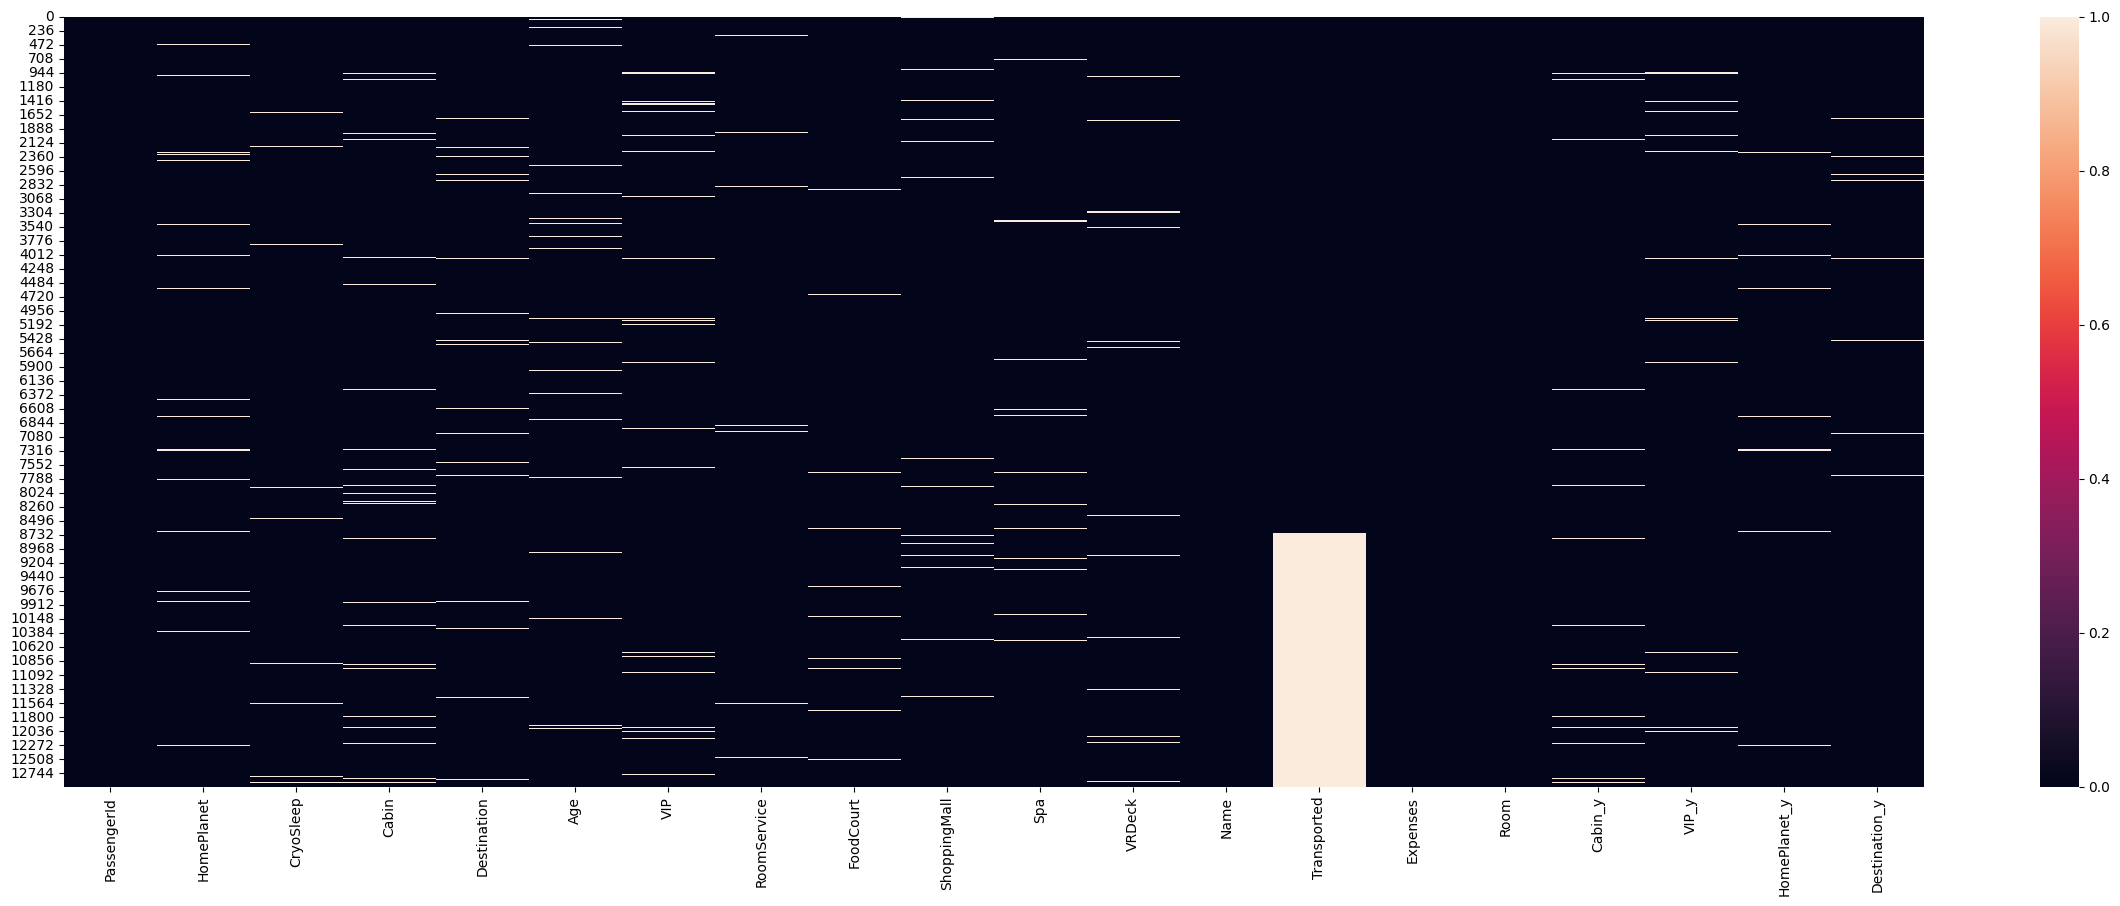

In [17]:
fig,ax = plt.subplots(figsize=(30,10))
pd.set_option('display.max_rows', 100)
print(train_test.isnull().sum())
sns.heatmap(train_test.isnull())

출발지 - 도착지

In [18]:
analys = train_test.loc[:,['HomePlanet','Destination']]
analys.groupby(['Destination', 'HomePlanet']).value_counts()

Destination    HomePlanet
55 Cancri e    Earth          984
               Europa        1310
               Mars           294
PSO J318.5-22  Earth         1065
               Europa          29
               Mars            67
TRAPPIST-1e    Earth         4672
               Europa        1737
               Mars          2256
dtype: int64

컬럼을 나누거나 필요없는 칼럼을 제거

In [19]:
train_test.loc[:,['Cabin_1']] = train_test.Cabin.str.split("/",expand=True).iloc[:,0]
train_test.loc[:,['Cabin_2']] = train_test.Cabin.str.split("/",expand=True).iloc[:,1]
train_test.loc[:,['Cabin_3']] = train_test.Cabin.str.split("/",expand=True).iloc[:,2]

In [20]:
train_test.loc[:,['FirstName']] = train_test.Name.str.split(" ",expand=True).iloc[:,0]
train_test.loc[:,['SecondName']] = train_test.Name.str.split(" ",expand=True).iloc[:,1]
train_test['Name_key']=train_test['SecondName']+train_test['Room']

In [21]:
train_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Cabin_y,VIP_y,HomePlanet_y,Destination_y,Cabin_1,Cabin_2,Cabin_3,FirstName,SecondName,Name_key
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,B/0/P,False,Europa,TRAPPIST-1e,B,0,P,Maham,Ofracculy,Ofracculy0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,F/0/S,False,Earth,TRAPPIST-1e,F,0,S,Juanna,Vines,Vines0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,A/0/S,True,Europa,TRAPPIST-1e,A,0,S,Altark,Susent,Susent0003


SimpleImputer로 null 값 없애고, 원핫인코딩

In [22]:
# 숫자 칼럼, 카테고리 칼럼, 타겟 칼럼 나눠놓기
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Cabin_1','Cabin_3','VIP','HomePlanet','Destination']
transported=['Transported']

In [23]:
train_test = train_test[num_cols + cat_cols + transported].copy()

num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test[num_cols]),columns=num_cols)
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test[cat_cols]),columns=cat_cols)
temp_train = pd.DataFrame(ohe.fit_transform(train_test[cat_cols]),columns= ohe.get_feature_names_out())
train_test = train_test.drop(cat_cols,axis=1)
train_test = pd.concat([train_test,temp_train],axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### **모델링 - XGB**

In [24]:
train = train_test[train_test['Transported'].notnull()].copy()
train.Transported =train.Transported.astype('int')
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)

X = train.drop('Transported',axis=1)
y = train.Transported

In [25]:
X,y = shuffle(X,y)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [26]:
def get_score(model,X,y):
    n = cross_val_score(model,X,y,scoring ='accuracy',cv=20)
    return n

params_XGB_best ={'lambda': 3.0610042624477543,
             'alpha': 4.581902571574289,
             'colsample_bytree': 0.9241969052729379,
             'subsample': 0.9527591724824661,
             'learning_rate': 0.06672065863100594,
             'n_estimators': 725, #initial value is 651
             'max_depth': 5,
             'min_child_weight': 1,
             'num_parallel_tree': 1}

In [27]:
get_score(xgb.XGBClassifier(**params_XGB_best),X,y).mean()

0.8089324116743472

### **feature importance**
- permutation importance

<Axes: >

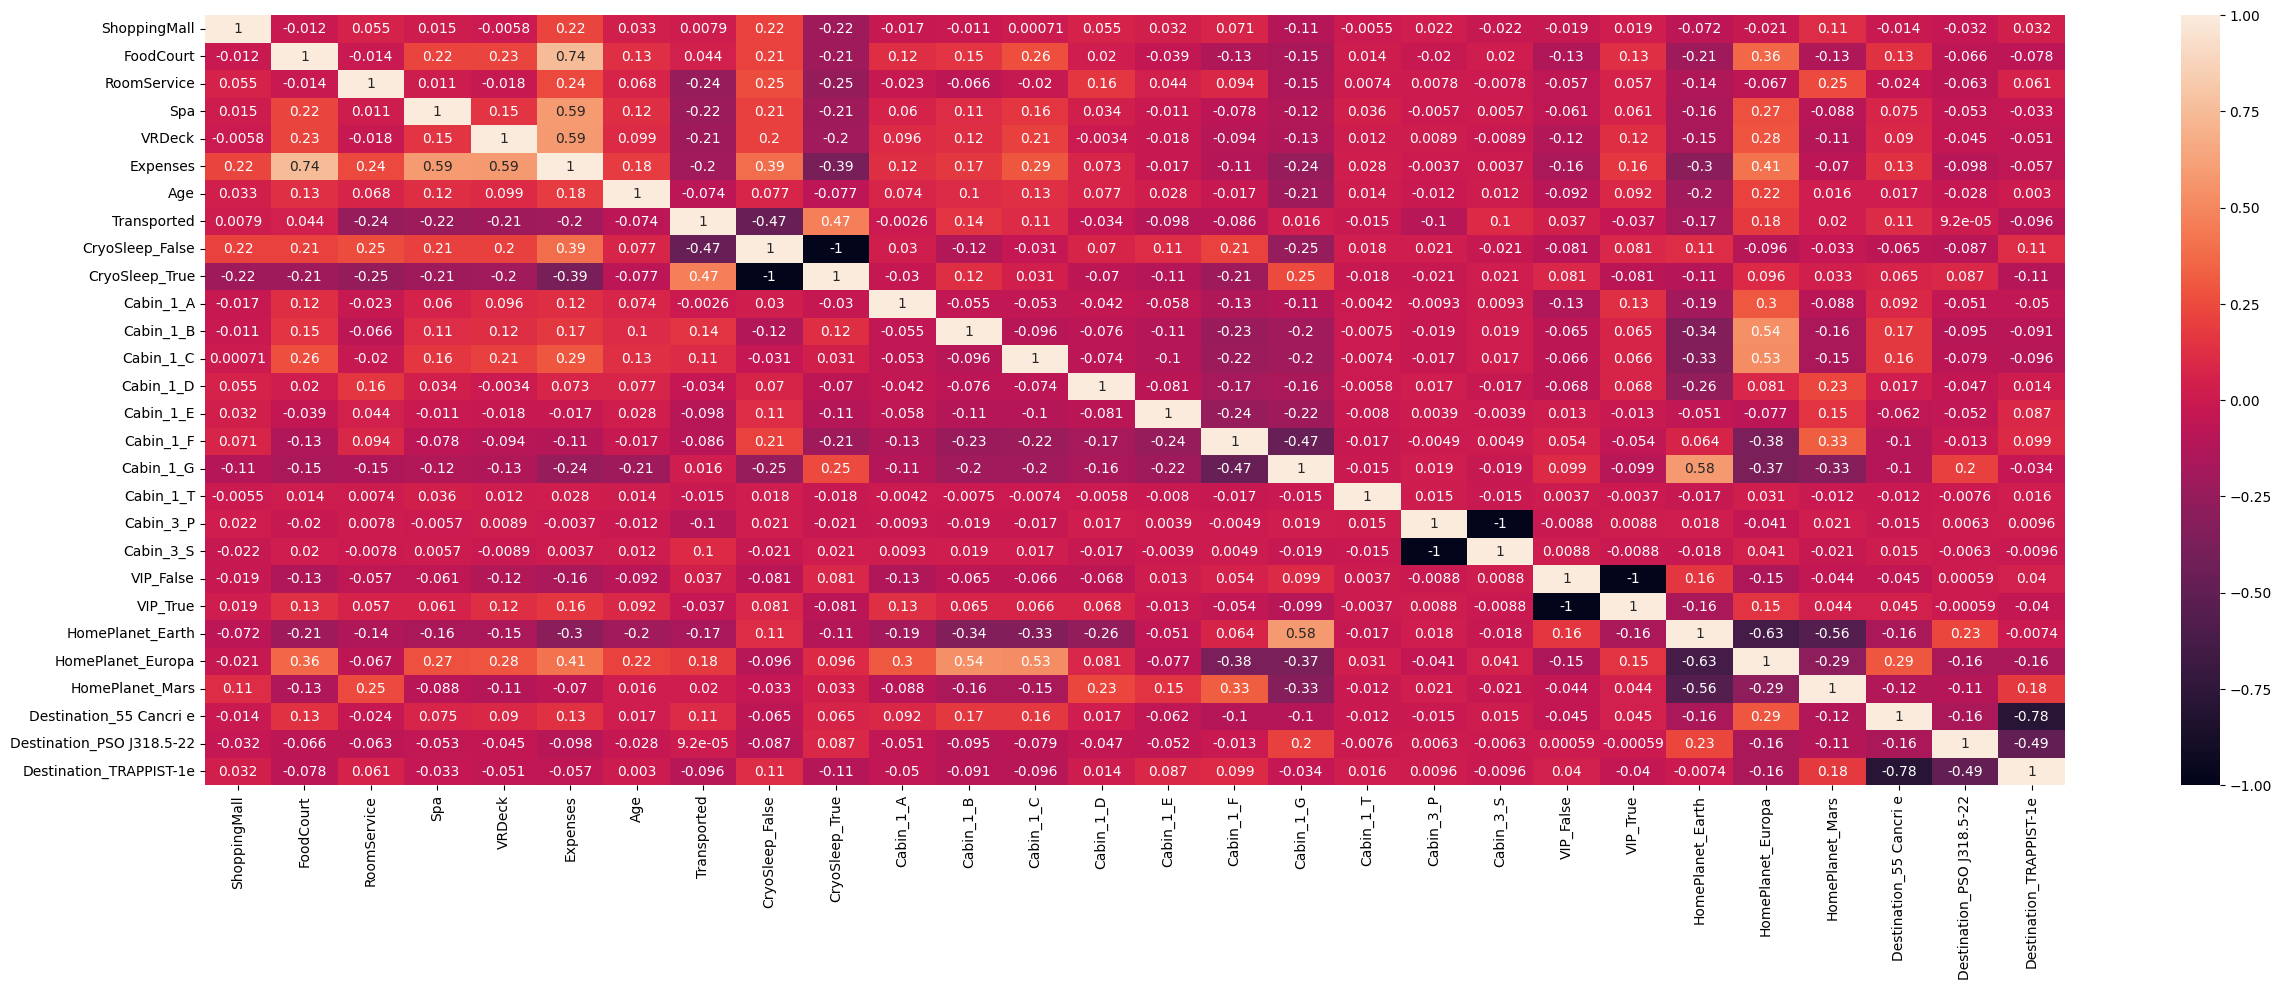

In [28]:
fig = plt.subplots(figsize=(30, 10))
sns.heatmap(train.corr(), annot=True)

In [ ]:
pip install eli5

In [30]:
import eli5
from eli5.sklearn import PermutationImportance

params_XGB_best= {'lambda': 3.0610042624477543,
             'alpha': 4.581902571574289,
             'colsample_bytree': 0.9241969052729379,
             'subsample': 0.9527591724824661,
             'learning_rate': 0.06672065863100594,
             'n_estimators': 725, #initial value is 651
             'max_depth': 5,
             'min_child_weight': 1,
             'num_parallel_tree': 1}

perm = PermutationImportance(xgb.XGBClassifier(**params_XGB_best), random_state=1,n_iter =10,cv=5).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist(),top=50)

Weight,Feature
0.0381 ± 0.0126,Spa
0.0357 ± 0.0134,FoodCourt
0.0355 ± 0.0102,VRDeck
0.0348 ± 0.0207,Expenses
0.0316 ± 0.0127,CryoSleep_False
0.0285 ± 0.0134,RoomService
0.0136 ± 0.0101,ShoppingMall
0.0097 ± 0.0147,Age
0.0093 ± 0.0110,Cabin_3_P
0.0089 ± 0.0059,Cabin_1_E


In [31]:
drop_list=['ShoppingMall','Age','CryoSleep_True','HomePlanet_Earth','HomePlanet_Europa',
'VIP_True','HomePlanet_Mars','Destination_PSO J318.5-22','VIP_False',
'Destination_55 Cancri e','FoodCourt','Destination_TRAPPIST-1e']

X=X.drop(drop_list,axis=1)
test=test.drop(drop_list,axis=1)

print(get_score(xgb.XGBClassifier(**params_XGB_best),X,y).mean())

0.8073203029821496


### **모델링 - LGBM**


In [32]:
optuna_study = "ON"
LGBM_study = "OFF"
XGB_study = "OFF"
CAT_study = "OFF"

gpu_switch = "OFF"
skf = StratifiedKFold(n_splits=10)

In [33]:
if gpu_switch == "ON":
    method = "gpu"
else:
    method = "cpu"

def objective(trial):
    param = {
     'objective': 'binary',
     'device': method,
     'metric': 'binary_logloss',
     'verbosity': -1,
     'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
     'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
     'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
     'num_leaves': trial.suggest_int('num_leaves', 2, 512),
     'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
     'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
     'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     'n_estimators' : trial.suggest_int('n_estimators', 100, 20000),
     'subsample':None,
     'subsample_freq':None,
     'reg_alpha':None,
     'colsample_bytree':None,
     'reg_lambda':None,
     'early_stopping_round':trial.suggest_int('early_stopping_round', 200, 200)
            }
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], yi.loc[test_index]
        model = lgb.LGBMClassifier(**param).fit(train_X,train_y,
                                            eval_set=[(valid_X,valid_y)],
                                            callbacks=[lgb.log_evaluation(period=0, show_stdv=False)]
                                             )
        n_iteration = model.best_iteration_
        n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        i=int(sum(n_iterations)/len(n_iterations))
    print("Average n_ite=" + str(i))
    print("% of scatter =" + str(np.std(n_iterations)/i))
    n=sum(results)/len(results)
    print(n)
    print("FIIINISH__________________________________\n")

    return n

if optuna_study == LGBM_study:
    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
    study.optimize(objective, n_trials=10000)
    print('Best trial:', study.best_trial.params)

In [ ]:
params_LGBM= {'lambda_l1': 6.183557865875619,
              'lambda_l2': 0.011470762415538793,
              'learning_rate': 0.08693013162698361,
              'num_leaves': 330,
              'feature_fraction': 0.6583455294128855,
              'bagging_fraction': 0.8666491286986552,
              'bagging_freq': 1,
              'min_child_samples': 17,
              'n_estimators': 739}

### **모델링 - xgb2**

In [34]:
if gpu_switch == "ON":
    method = "gpu_hist"
else:
    method = "hist"

def objective(trial):
    print("START__________________________________")
    param = {
        'tree_method':method,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,3000),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,1),
        #'early_stopping_rounds':200,
        }

    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = xgb.XGBClassifier(**param).fit(train_X,train_y,
                                      eval_set=[(valid_X,valid_y)],
                                      verbose=0
                                     )
        #n_iteration = model.get_booster().best_iteration
        #n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        #i=int(sum(n_iterations)/len(n_iterations))
   # print("Average n_ite=" + str(i))
   # print("% of scatter =" + str(np.std(n_iterations)/i))
    n=sum(results)/len(results)
    print (n)
    print("FIIINISH__________________________________\n")
    return n

if optuna_study == XGB_study:
    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
    study.optimize(objective, n_trials=1000)

In [35]:
params_XGB_best= {'lambda': 3.0610042624477543,
             'alpha': 4.581902571574289,
             'colsample_bytree': 0.9241969052729379,
             'subsample': 0.9527591724824661,
             'learning_rate': 0.06672065863100594,
             'n_estimators': 730, #initial value is 651
             'max_depth': 5,
             'min_child_weight': 1,
             'num_parallel_tree': 1}

## **제출**

In [37]:
sample = pd.read_csv('sample_submission.csv')

In [38]:
pred_XGB_best = (xgb.XGBClassifier(**params_XGB_best).fit(X,y)).predict(test)
sample['Transported'] = pred_XGB_best
sample['Transported']=sample['Transported']>0.5
sample.to_csv('XGB_best.csv', index=False)